In [49]:
import pandas as pd
import geopandas as gpd
import seaborn as sns

import gcsfs

import itertools

Read in data

In [7]:
gcs_path = 'gs://smart4'

count_data = pd.read_csv(f'{gcs_path}/count_file/Final_data_feb8.csv')

segment_geos = gpd.read_file(f'{gcs_path}/count_file/Revised_Estimated_SC_ATT_Feb9.geojson')

places = gpd.read_file(f'{gcs_path}/context_data/census/tl_2021_06_place')

counties = gpd.read_file(f'{gcs_path}/context_data/census/tl_2021_us_county')
counties = counties.query("STATEFP == '06'")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# join the geometries to the attributes
count_data = count_data.join(segment_geos.set_index(['matched_se', 'year'])[['geometry']],
                on=['matched_seg_id', 'year'])

count_data = count_data.drop(columns=['Unnamed: 0'])

In [9]:
count_data = gpd.GeoDataFrame(count_data)

In [64]:
count_data.duplicated(subset=['tdg_id', 'year']).sum()

387

In [10]:
# Join the place and county names to the segments for increased legibility
places = places.to_crs(count_data.crs)
counties = counties.to_crs(count_data.crs)

# Traffic data exploration
Let's start with an exploration of our imputed bike traffic volumes. First I'm going to switch this to a more standard AADT.

In [20]:
count_data['aadt'] = count_data['ATT']/365.

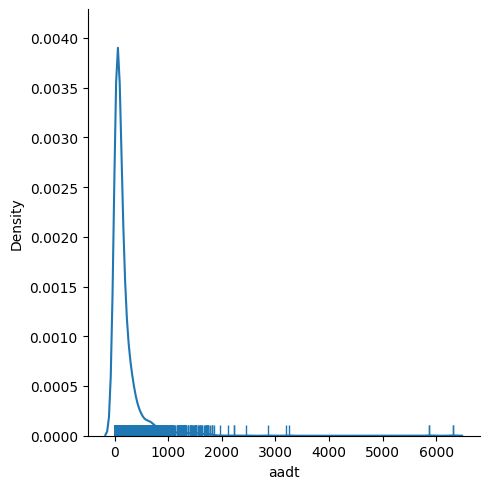

In [21]:
sns.displot(count_data['aadt'], kind='kde', rug=True)

In [34]:
count_data.sort_values('aadt', ascending=False)[['year', 'tdg_id', 'aadt', 'street_name', 'county']].head(20)

,year,tdg_id,aadt,street_name,county
1113,2015,64850,6310.145205,Pacific Avenue,Los Angeles
1112,2015,64682,6310.145205,Pacific Avenue,Los Angeles
1335,2015,64854,5874.534247,Pacific Avenue,Los Angeles
1334,2015,64618,5874.534247,Pacific Avenue,Los Angeles
2628,2016,135675,3251.665753,A Street,Yolo
1053,2015,53590,3195.613699,South Los Angeles Street,Los Angeles
2284,2016,135674,2854.597260,A Street,Yolo
1694,2016,58948,2451.128767,Packard Street,Los Angeles
19,2014,50943,2226.783562,West Olympic Boulevard,Los Angeles
2636,2016,135745,2221.435616,B Street,Yolo


Some of these seem erroneous - especially those over 5000/day. Let's check out a map of those over 2000/day.

In [36]:
count_data.query("aadt > 5000 & county == 'Los Angeles'").explore('aadt', cmap='jet')

FOLLOW UP: This looks like a street that would have street festivals and things - make sure the short duration counts weren't collected during such an event.

In [40]:
count_data.query("aadt < 5000 & aadt > 1000 & county == 'Los Angeles'")[['aadt', 'year', 'street_name', 'geometry']].explore('aadt', cmap='jet')

In [37]:
count_data.query("aadt > 1500 & county == 'Yolo'").explore('aadt', cmap='jet')

That seems more believable, considering it's right off the UC Davis campus

FOLLOW UP: Mintu to look into outliers and make sure there weren't special events or something happening.

# Strava columns
Next, we'll look into all the Strava columns.

In [53]:
strava_column_templates = [
    '{direction}_trip_count_{year}_{distance}',
    '{direction}_commute_trip_count_{year}_{distance}',
    '{direction}_leisure_trip_count_{year}_{distance}',
    '{direction}_average_speed_{year}_{distance}']

directions = ['forward', 'reverse']
years = [2018, 2019, 2020, 2021]
distances = ['t', 'q', 'h']

strava_col_params = [{'direction': q[0], 'year': q[1], 'distance': q[2]} 
                     for q in itertools.product(directions, years, distances)]

strava_cols = []
for template in strava_column_templates:
    for params in strava_col_params:
        strava_cols.append(template.format(**params))

In [66]:
strava_wide = count_data[['tdg_id', 'year'] + strava_cols]
strava_long = strava_wide.melt(id_vars=['tdg_id', 'year'])

In [78]:
strava_long['strava_direction'] = strava_long['variable'].str.split('_').str[0]
strava_long['strava_distance'] = strava_long['variable'].str.split('_').str[-1]
strava_long['strava_year'] = strava_long['variable'].str.split('_').str[-2]
strava_long['strava_variable'] = strava_long['variable'].str.split('_').str[1:-2].str.join('_')

In [87]:
strava_long['year_diff'] = strava_long['strava_year'].astype(int) - strava_long['year']

In [88]:
strava_long

,tdg_id,year,variable,value,strava_direction,strava_distance,strava_year,strava_variable,year_diff
0,6191,2014,forward_trip_count_2018_t,8265.00,forward,t,2018,trip_count,4
1,6191,2015,forward_trip_count_2018_t,8265.00,forward,t,2018,trip_count,3
2,6234,2014,forward_trip_count_2018_t,14195.00,forward,t,2018,trip_count,4
3,39019,2014,forward_trip_count_2018_t,400.00,forward,t,2018,trip_count,4
4,39019,2015,forward_trip_count_2018_t,400.00,forward,t,2018,trip_count,3
...,...,...,...,...,...,...,...,...,...
469627,80599,2019,reverse_average_speed_2021_h,2.54,reverse,h,2021,average_speed,2
469628,80666,2019,reverse_average_speed_2021_h,2.81,reverse,h,2021,average_speed,2
469629,80782,2019,reverse_average_speed_2021_h,7.10,reverse,h,2021,average_speed,2
469630,80797,2019,reverse_average_speed_2021_h,6.96,reverse,h,2021,average_speed,2


In [79]:
strava_long.groupby(['tdg_id', 'year', 'strava_variable', 'strava_direction', 'strava_distance']).\
    

,tdg_id,year,variable,value,strava_direction,strava_distance,strava_year,strava_variable
0,6191,2014,forward_trip_count_2018_t,8265.00,forward,t,2018,trip_count
1,6191,2015,forward_trip_count_2018_t,8265.00,forward,t,2018,trip_count
2,6234,2014,forward_trip_count_2018_t,14195.00,forward,t,2018,trip_count
3,39019,2014,forward_trip_count_2018_t,400.00,forward,t,2018,trip_count
4,39019,2015,forward_trip_count_2018_t,400.00,forward,t,2018,trip_count
...,...,...,...,...,...,...,...,...
469627,80599,2019,reverse_average_speed_2021_h,2.54,reverse,h,2021,average_speed
469628,80666,2019,reverse_average_speed_2021_h,2.81,reverse,h,2021,average_speed
469629,80782,2019,reverse_average_speed_2021_h,7.10,reverse,h,2021,average_speed
469630,80797,2019,reverse_average_speed_2021_h,6.96,reverse,h,2021,average_speed
